In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to GANs

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture. 

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN. 



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [ ]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

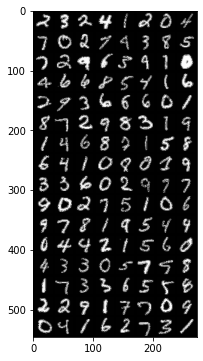

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm 
- ReLU

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.Tanh()
        )
        
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )



class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            get_upscaling_block(nz, 4*ngf, kernel=4, stride=1, padding=0),
            get_upscaling_block(4*ngf, 2*ngf, kernel=4, stride=2, padding=1),
            get_upscaling_block(2*ngf, ngf, kernel=4, stride=2, padding=1),
            get_upscaling_block(ngf, nchannels, kernel=4, stride=2, padding=1, last_layer=True)
        )
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)
        

### 2.1.3. Sanity Tests

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

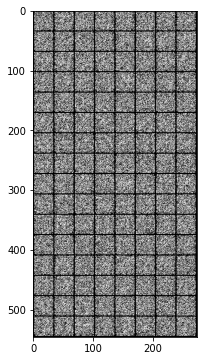

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake_first = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake_first, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator. 

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]` 

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    if is_last:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.Sigmoid()
        )
    
    elif not use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.LeakyReLU(0.2)
        )
    
    else:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.LeakyReLU(0.2)
        )
    
    

class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            get_downscaling_block(nchannels, ndf, kernel=4, stride=2, padding=1),
            get_downscaling_block(ndf, 2*ndf, kernel=4, stride=2, padding=1),
            get_downscaling_block(2*ndf, 4*ndf, kernel=4, stride=2, padding=1),
            get_downscaling_block(4*ndf, 1, kernel=4, stride=1, padding=0, is_last=True)
        )
        
    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss 
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions. 
1. First, we need to continuously sample z from a Gaussian distribution. 
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s. 

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [ ]:
nz = 50
ngf = 64
ndf = 64

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
print(netG)
print(netD)

Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(50, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)
Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding

## 3.3 Training!

Now for the fun part, training! 
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve. 
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 1.2320643663406372; d_loss: 2.008974552154541; avg_real_score: 0.22868648171424866; avg_fake_score: 0.33383655548095703: : 0it [00:00, ?it/s]

generated images


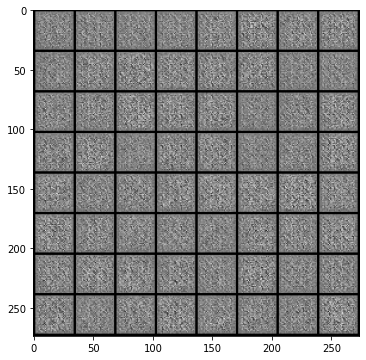

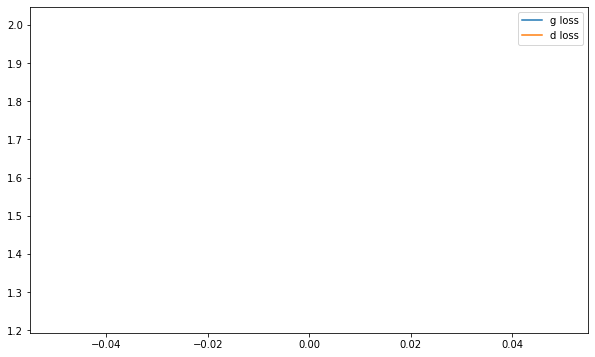

it: 0; g_loss: 2.863340139389038; d_loss: 0.6776018738746643; avg_real_score: 0.8751204013824463; avg_fake_score: 0.4004048705101013: : 200it [00:14, 15.06it/s]  

generated images


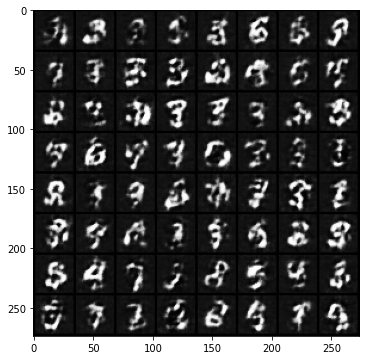

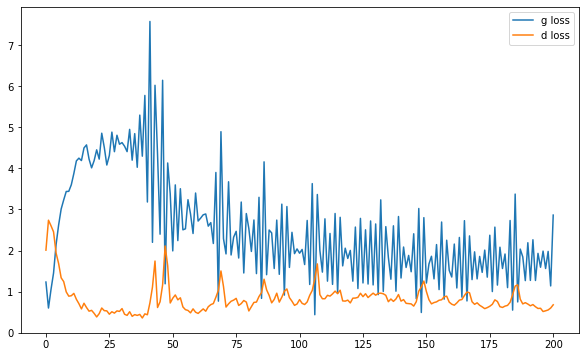

it: 0; g_loss: 1.071428656578064; d_loss: 0.7180550694465637; avg_real_score: 0.5972245335578918; avg_fake_score: 0.15084974467754364: : 400it [00:41,  6.31it/s]

generated images


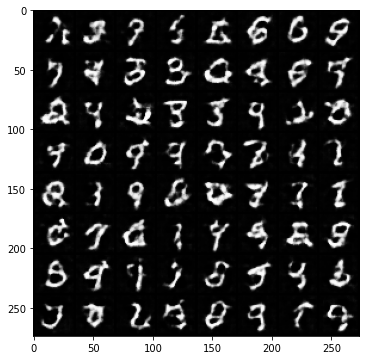

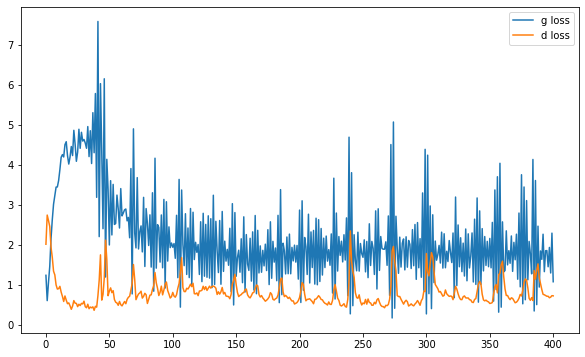

it: 0; g_loss: 1.881264090538025; d_loss: 0.6781978607177734; avg_real_score: 0.7527027130126953; avg_fake_score: 0.3009306788444519: : 469it [00:49,  9.49it/s]
it: 1; g_loss: 1.6162233352661133; d_loss: 0.6651241779327393; avg_real_score: 0.6822980642318726; avg_fake_score: 0.22197014093399048: : 0it [00:00, ?it/s]

generated images


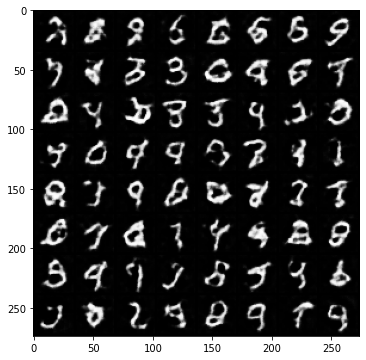

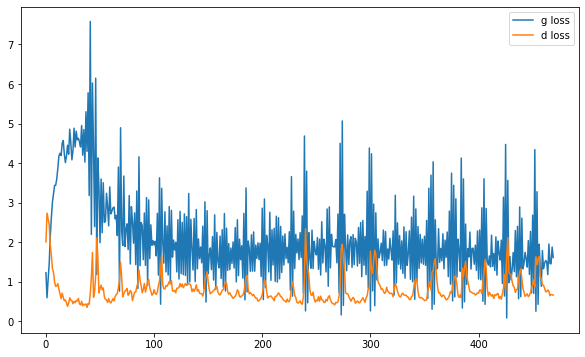

it: 1; g_loss: 1.154954433441162; d_loss: 0.7484995722770691; avg_real_score: 0.6217459440231323; avg_fake_score: 0.2166748344898224: : 199it [00:14, 14.47it/s] 

generated images


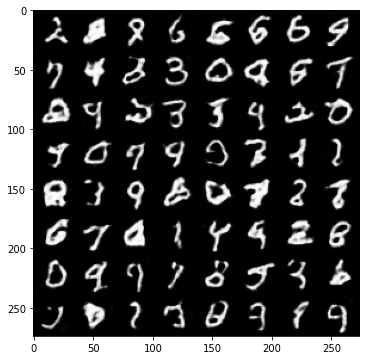

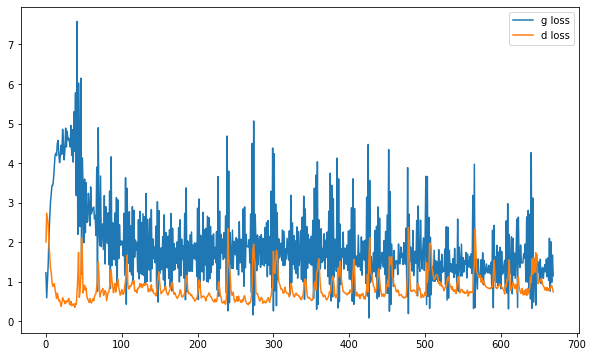

it: 1; g_loss: 1.6563942432403564; d_loss: 1.0801836252212524; avg_real_score: 0.6889400482177734; avg_fake_score: 0.4756191074848175: : 400it [00:30,  7.39it/s] 

generated images


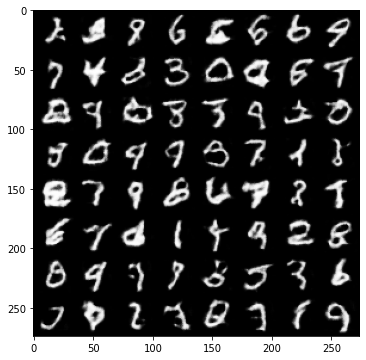

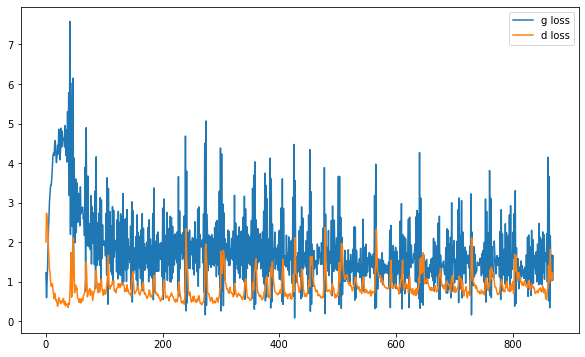

it: 1; g_loss: 1.2738760709762573; d_loss: 0.8338350653648376; avg_real_score: 0.5697848200798035; avg_fake_score: 0.20117239654064178: : 469it [00:38, 12.27it/s]
it: 2; g_loss: 2.3469090461730957; d_loss: 0.8172572255134583; avg_real_score: 0.8065134882926941; avg_fake_score: 0.430791437625885: : 0it [00:00, ?it/s]

generated images


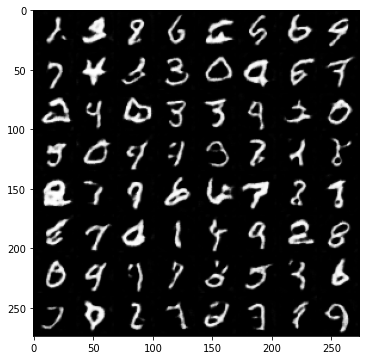

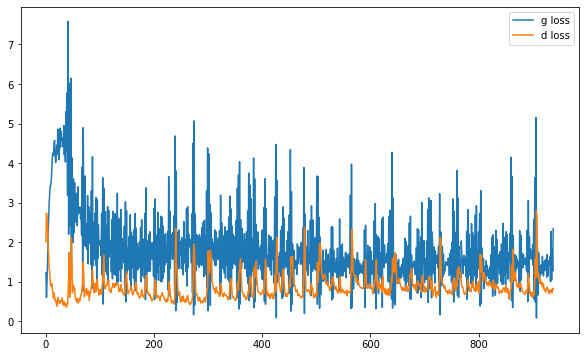

it: 2; g_loss: 1.816224217414856; d_loss: 0.780012309551239; avg_real_score: 0.7994056940078735; avg_fake_score: 0.39956945180892944: : 200it [00:19,  7.72it/s] 

generated images


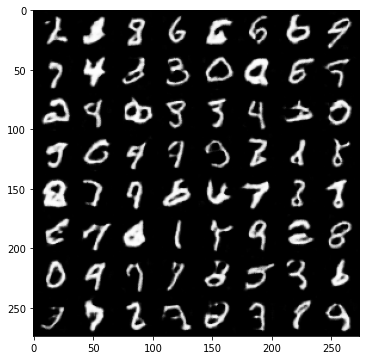

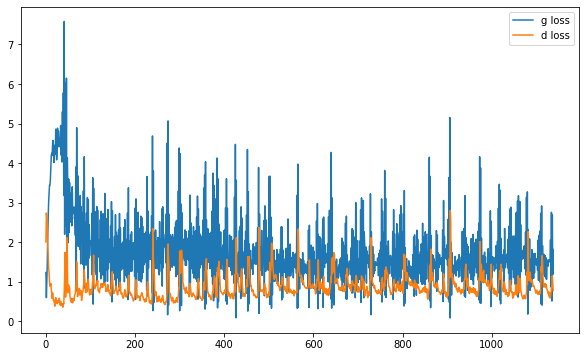

it: 2; g_loss: 1.8480937480926514; d_loss: 0.5123454332351685; avg_real_score: 0.7413134574890137; avg_fake_score: 0.17436203360557556: : 399it [00:41,  6.31it/s]

generated images


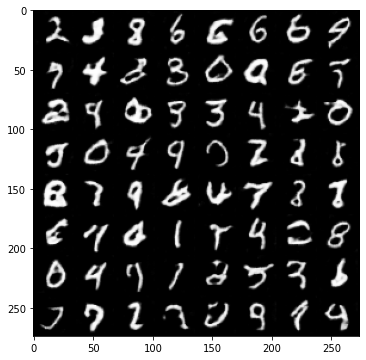

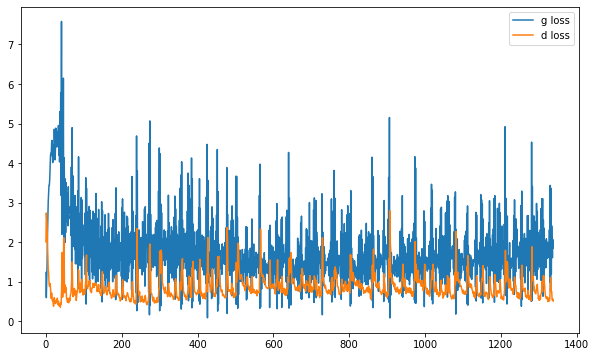

it: 2; g_loss: 1.8731951713562012; d_loss: 0.7962243556976318; avg_real_score: 0.5677978992462158; avg_fake_score: 0.13528123497962952: : 469it [00:50,  9.26it/s]
it: 3; g_loss: 1.4199388027191162; d_loss: 0.8931731581687927; avg_real_score: 0.6845937371253967; avg_fake_score: 0.3620299994945526: : 0it [00:00, ?it/s]

generated images


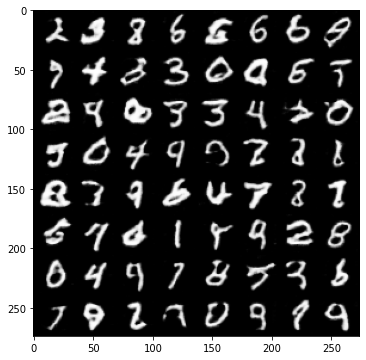

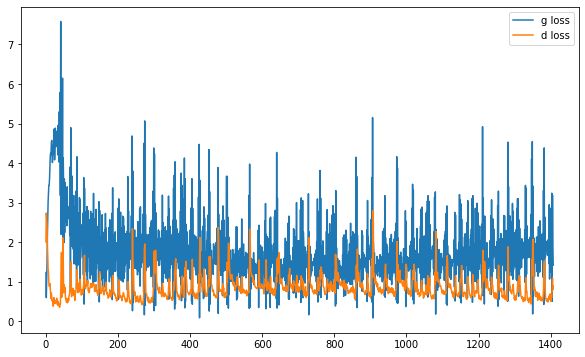

it: 3; g_loss: 2.949448585510254; d_loss: 0.6837486624717712; avg_real_score: 0.8959205150604248; avg_fake_score: 0.4085486829280853: : 199it [00:14, 13.64it/s] 

generated images


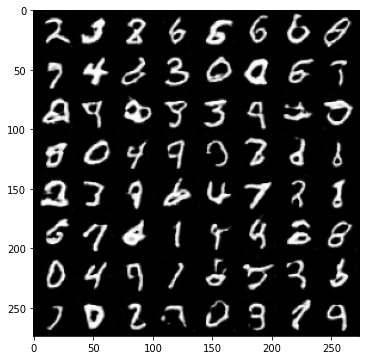

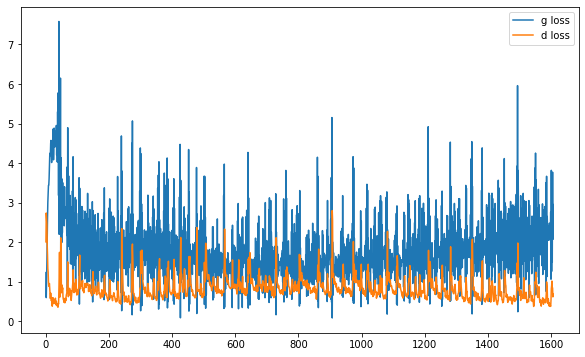

it: 3; g_loss: 2.2248334884643555; d_loss: 0.3606943190097809; avg_real_score: 0.8641338348388672; avg_fake_score: 0.18059934675693512: : 399it [00:29, 14.01it/s] 

generated images


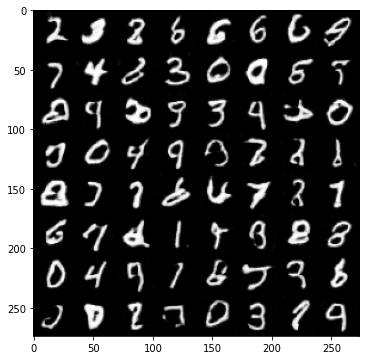

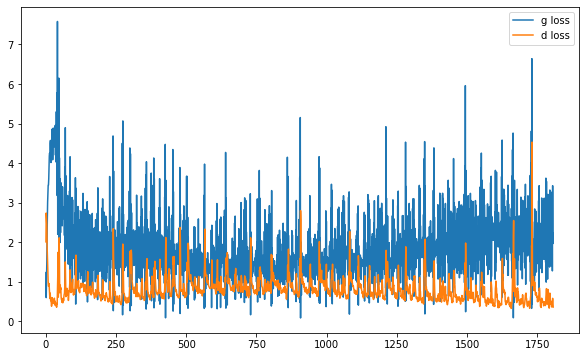

it: 3; g_loss: 0.1489383578300476; d_loss: 2.751901626586914; avg_real_score: 0.09699498862028122; avg_fake_score: 0.04160450026392937: : 469it [00:35, 13.28it/s]
it: 4; g_loss: 4.742025852203369; d_loss: 1.9859541654586792; avg_real_score: 0.9934254884719849; avg_fake_score: 0.8203326463699341: : 0it [00:00, ?it/s]

generated images


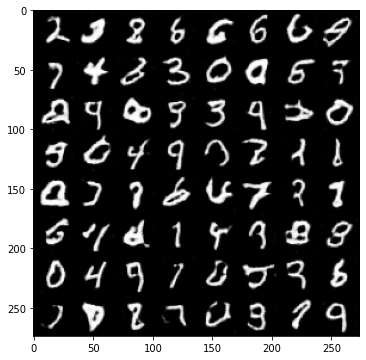

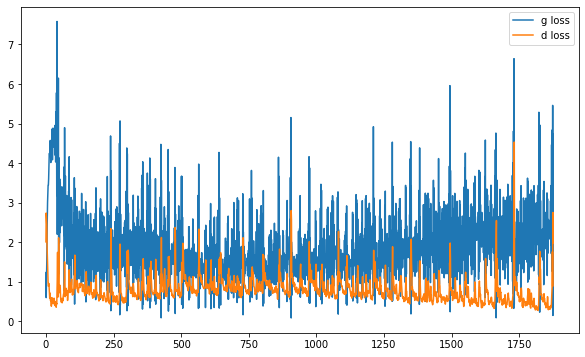

it: 4; g_loss: 0.8950048685073853; d_loss: 0.7999610304832458; avg_real_score: 0.538320779800415; avg_fake_score: 0.12113258987665176: : 200it [00:19,  5.71it/s]

generated images


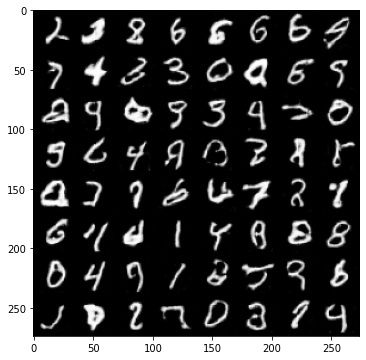

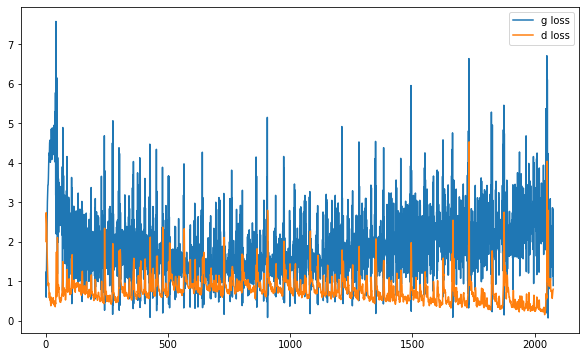

it: 4; g_loss: 3.1200942993164062; d_loss: 0.3133174479007721; avg_real_score: 0.9502401351928711; avg_fake_score: 0.22120244801044464: : 399it [00:35, 13.27it/s]

generated images


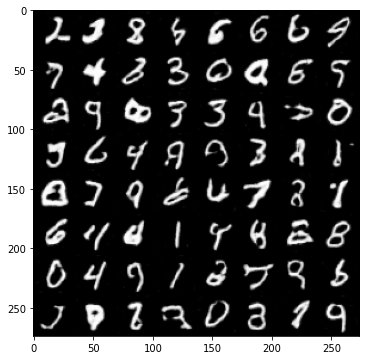

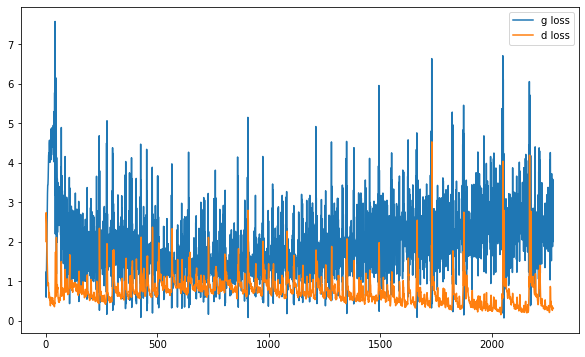

it: 4; g_loss: 3.0842533111572266; d_loss: 0.21056923270225525; avg_real_score: 0.9475017786026001; avg_fake_score: 0.13876545429229736: : 469it [00:41, 11.19it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []



z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        imD = im.to(device)
        
        cur_batch_size = imD.shape[0]
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector
        z1 = sample_z(cur_batch_size, nz)
        
        # 2. Generate a fake image
        x_fake = netG(z1)

        # 3. Classify real image with D
        y_hat_real = netD(imD)

        # 4. Classify fake image with D
        y_hat_fake = netD(x_fake)
        
        y_real, y_fake = get_labels_one(cur_batch_size), get_labels_zero(cur_batch_size)

        ###
        ### Discriminator
        ###
        
        d_loss = criterion(y_hat_real, y_real) + criterion(y_hat_fake, y_fake)
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        
        g_loss = criterion(netD(x_fake), y_real)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = y_hat_real.mean().item()
        avg_fake_score = y_hat_fake.mean().item()

        pbar.set_description(f"it: {epoch}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()